# Predicción de Diabetes mediante Árboles de Decisión

En este proyecto se desarrolla un modelo predictivo para determinar si un paciente presenta diabetes en función de diferentes variables biomédicas. El dataset empleado procede del estudio Pima Indians Diabetes, ampliamente utilizado para problemas de clasificación.

El trabajo sigue un enfoque académico estructurado:  
1. Análisis Exploratorio de Datos (EDA).  
2. Explicación detallada de cada variable.  
3. Construcción de un árbol de decisión complejo.  
4. Construcción de un árbol de decisión simple (regularizado).  
5. Comparación científica entre ambos modelos.  
6. Optimización mediante GridSearchCV.  
7. Conclusiones finales.

Todas las observaciones contienen comentarios propios del análisis realizado.


In [1]:
"""
En esta celda importo todas las librerías necesarias para el análisis.
Incluyen herramientas de manipulación de datos (pandas), visualización (matplotlib, seaborn),
modelado (sklearn) y guardado de modelos (joblib).
"""

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import joblib  # para guardar el modelo

plt.style.use('default')


In [2]:
"""
Cargo el dataset diabetes.csv localizado en la misma carpeta del notebook.
Muestro dimensiones y primeras filas para revisar su estructura.
"""

df = pd.read_csv("../data/raw/diabetes.csv") # 2. Cargar el dataset
print("Dimensiones del dataset:", df.shape) # Comprobar dimensiones y primeras filas
df.head()



Dimensiones del dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Descripción individual de cada variable del dataset

A continuación, describo académicamente cada variable del conjunto de datos, indicando su función y posibles interpretaciones clínicas:

- **Pregnancies**: Número de embarazos que ha tenido la paciente. Variable relevante porque el embarazo puede aumentar riesgo metabólico.
- **Glucose**: Concentración de glucosa en plasma tras 2 horas de una prueba de tolerancia. Es una de las variables más predictivas en el diagnóstico.
- **BloodPressure**: Presión arterial diastólica (mmHg). Valores bajos o 0 pueden indicar datos faltantes codificados erróneamente.
- **SkinThickness**: Grosor del pliegue cutáneo del tríceps (mm). Puede relacionarse con la distribución de grasa subcutánea.
- **Insulin**: Concentración de insulina sérica a las 2 horas. Valores 0 reflejan ausencia de medición.
- **BMI**: Índice de masa corporal (kg/m2). La obesidad es un factor clave en diabetes tipo 2.
- **DiabetesPedigreeFunction**: Valor que representa la probabilidad genética de presentar diabetes según antecedentes familiares.
- **Age**: Edad del paciente. La probabilidad aumenta con la edad.
- **Outcome**: Variable objetivo. 0 = no diabética, 1 = diabética.

Este análisis permite comprender qué aporta cada variable al modelo predictivo.


In [3]:
"""
Analizo la estructura general del dataset para comprobar tipos de datos,
cantidades y formato de cada columna.
"""

df.info() # Info general



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
"""
Muestro estadísticas descriptivas para evaluar el comportamiento numérico y 
posibles valores extremos o atípicos.
"""

df.describe() # Descripción estadística


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
"""
Reviso si existen valores nulos explícitos y analizo la distribución de la variable objetivo (Outcome),
que indica si el paciente tiene o no diabetes. Esto determina si hay desbalanceo en las clases.
"""

print("Valores nulos por columna:")
print(df.isnull().sum()) # Comprobar valores nulos

print("\nDistribución de la variable Outcome:")
print(df['Outcome'].value_counts()) # Distribución de la variable objetivo
print(df['Outcome'].value_counts(normalize=True))


Valores nulos por columna:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Distribución de la variable Outcome:
Outcome
0    500
1    268
Name: count, dtype: int64
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


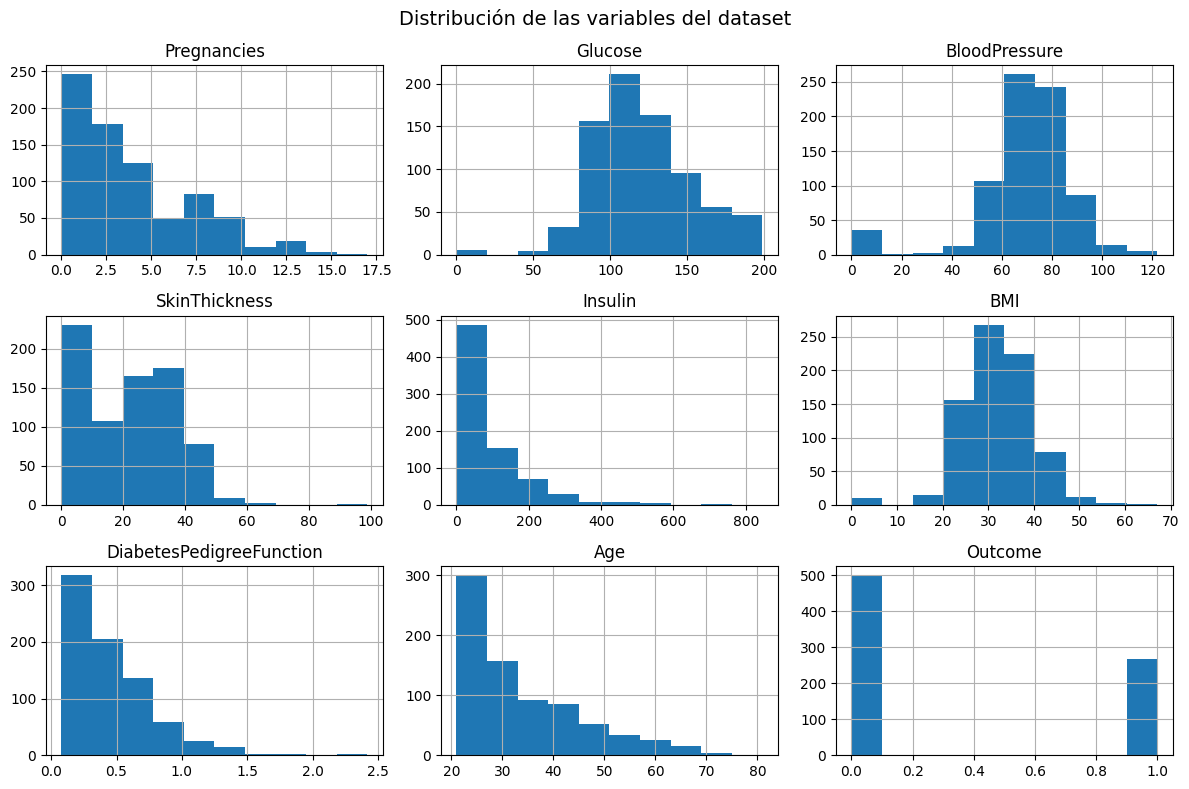

In [6]:
"""
Genero histogramas de todas las variables numéricas para visualizar su distribución.
Esto me permite comentar la forma de cada variable (asimetría, valores extremos, etc.).
"""

df.hist(figsize=(12, 8))
plt.suptitle("Distribución de las variables del dataset", fontsize=14)
plt.tight_layout()
plt.show() # Histograma de las variables numéricas


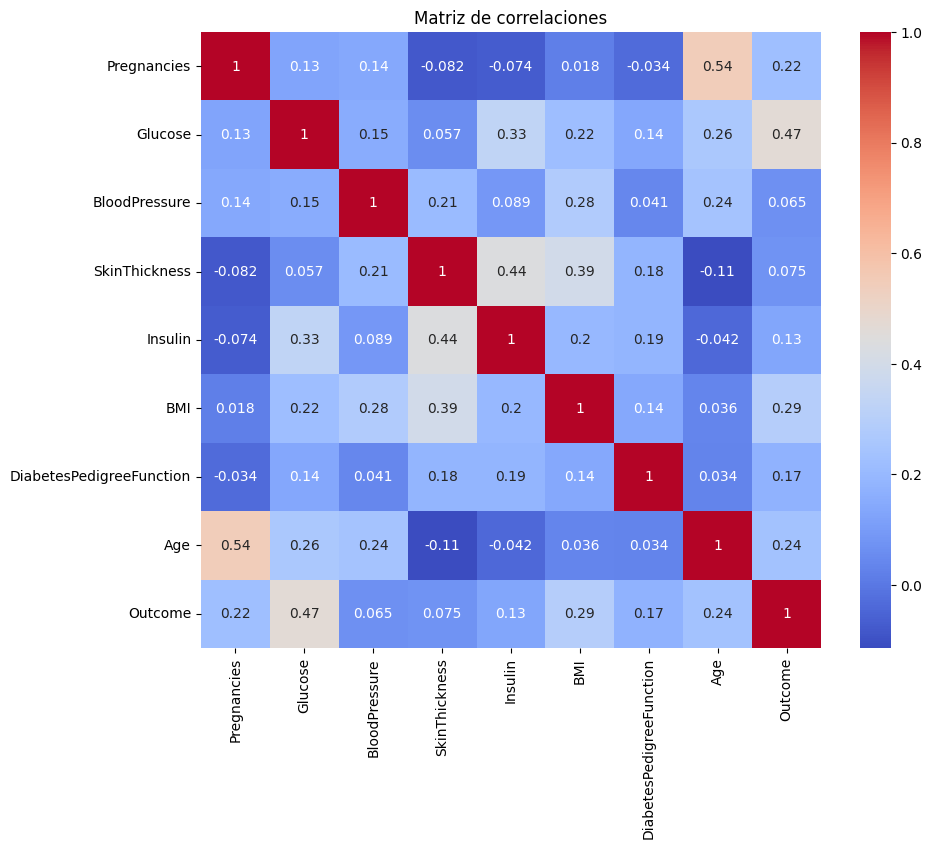

In [7]:
"""
Aquí analizo la correlación entre todas las variables y 'Outcome'.
Esta observación es fundamental para comprender qué variables aportan más información al modelo.
"""
# Matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de correlaciones")
plt.show()


## Comentarios personales del EDA

- No hay valores nulos explícitos, pero sí existen valores igual a cero que pueden representar datos no medidos.
- `Glucose` y `BMI` parecen ser las variables más relacionadas con diabetes.
- La mayoría de distribuciones son asimétricas, lo cual es habitual en datos clínicos.
- La variable objetivo no está completamente balanceada, pero la proporción es aceptable para modelos clásicos.
- No se aprecia correlación excesiva entre variables que pueda afectar negativamente al modelo.

Este análisis permite justificar el uso de árboles de decisión sin transformación previa de las variables.


In [8]:
"""
Divido los datos en entrenamiento y prueba. Mantengo la proporción de clases (stratify)
para garantizar representatividad estadística.
"""
# 3. Definir X (features) e y (target)
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# 4. Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y # mantiene la proporción de clases
)

X_train.shape, X_test.shape


((614, 8), (154, 8))

Modelo de Árbol de Decisión con distintos criterio

In [9]:
# 5. Probar distintos criterios de pureza
criterios = ['gini', 'entropy']  # puedes añadir 'log_loss' si tu sklearn lo permite
resultados = {}

for crit in criterios:
    print("=" * 50)
    print(f"Entrenando árbol con criterio: {crit}")
    
    tree_clf = DecisionTreeClassifier(
        criterion=crit,
        random_state=42
    )
    
    tree_clf.fit(X_train, y_train)
    
    # Predicciones
    y_train_pred = tree_clf.predict(X_train)
    y_test_pred = tree_clf.predict(X_test)
    
    # Métricas
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)
    
    print(f"Accuracy en train: {acc_train:.4f}")
    print(f"Accuracy en test : {acc_test:.4f}")
    
    resultados[crit] = {
        'model': tree_clf,
        'acc_train': acc_train,
        'acc_test': acc_test
    }


Entrenando árbol con criterio: gini
Accuracy en train: 1.0000
Accuracy en test : 0.7273
Entrenando árbol con criterio: entropy
Accuracy en train: 1.0000
Accuracy en test : 0.7013


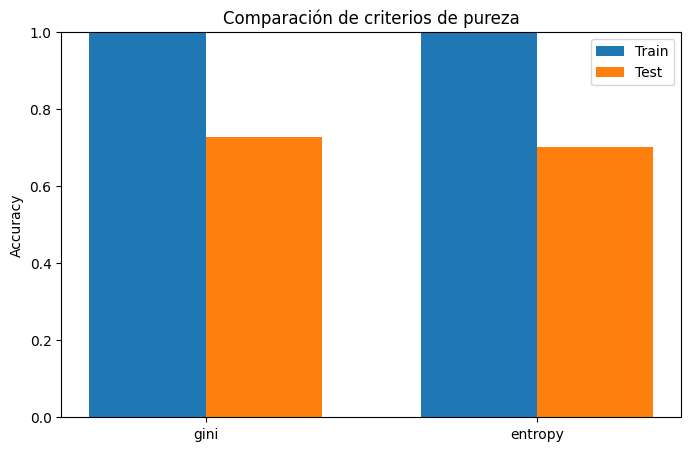

In [10]:
# Comparar accuracies de cada criterio
criterios_lista = list(resultados.keys())
acc_train_vals = [resultados[c]['acc_train'] for c in criterios_lista]
acc_test_vals = [resultados[c]['acc_test'] for c in criterios_lista]

x = np.arange(len(criterios_lista))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, acc_train_vals, width, label='Train')
plt.bar(x + width/2, acc_test_vals, width, label='Test')

plt.xticks(x, criterios_lista)
plt.ylabel("Accuracy")
plt.title("Comparación de criterios de pureza")
plt.legend()
plt.ylim(0, 1)
plt.show()


In [11]:
# Por ejemplo, supón que 'gini' me da mejor resultado en test:
mejor_criterio = max(resultados, key=lambda c: resultados[c]['acc_test'])
print("Mejor criterio según accuracy en test:", mejor_criterio)

mejor_modelo = resultados[mejor_criterio]['model']

y_test_pred = mejor_modelo.predict(X_test)

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification report:")
print(classification_report(y_test, y_test_pred))


Mejor criterio según accuracy en test: gini
Matriz de confusión:
[[85 15]
 [27 27]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       100
           1       0.64      0.50      0.56        54

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.68       154
weighted avg       0.72      0.73      0.72       154



In [12]:
# 6. Definir el modelo base con el mejor criterio
dt_clf = DecisionTreeClassifier(
    criterion=mejor_criterio,
    random_state=42
)

# Definir el grid de hiperparámetros
param_grid = {
    'max_depth': [3, 4, 5, 6, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=dt_clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor accuracy (cv):", grid_search.best_score_)


Mejores hiperparámetros: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}
Mejor accuracy (cv): 0.7557243769159003


In [13]:
# 7. Evaluo el mejor modelo en el set de test
best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(X_test)

print("Accuracy en test del mejor modelo:", accuracy_score(y_test, y_test_pred))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))


Accuracy en test del mejor modelo: 0.6753246753246753

Matriz de confusión:
[[81 19]
 [31 23]]

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       100
           1       0.55      0.43      0.48        54

    accuracy                           0.68       154
   macro avg       0.64      0.62      0.62       154
weighted avg       0.66      0.68      0.66       154



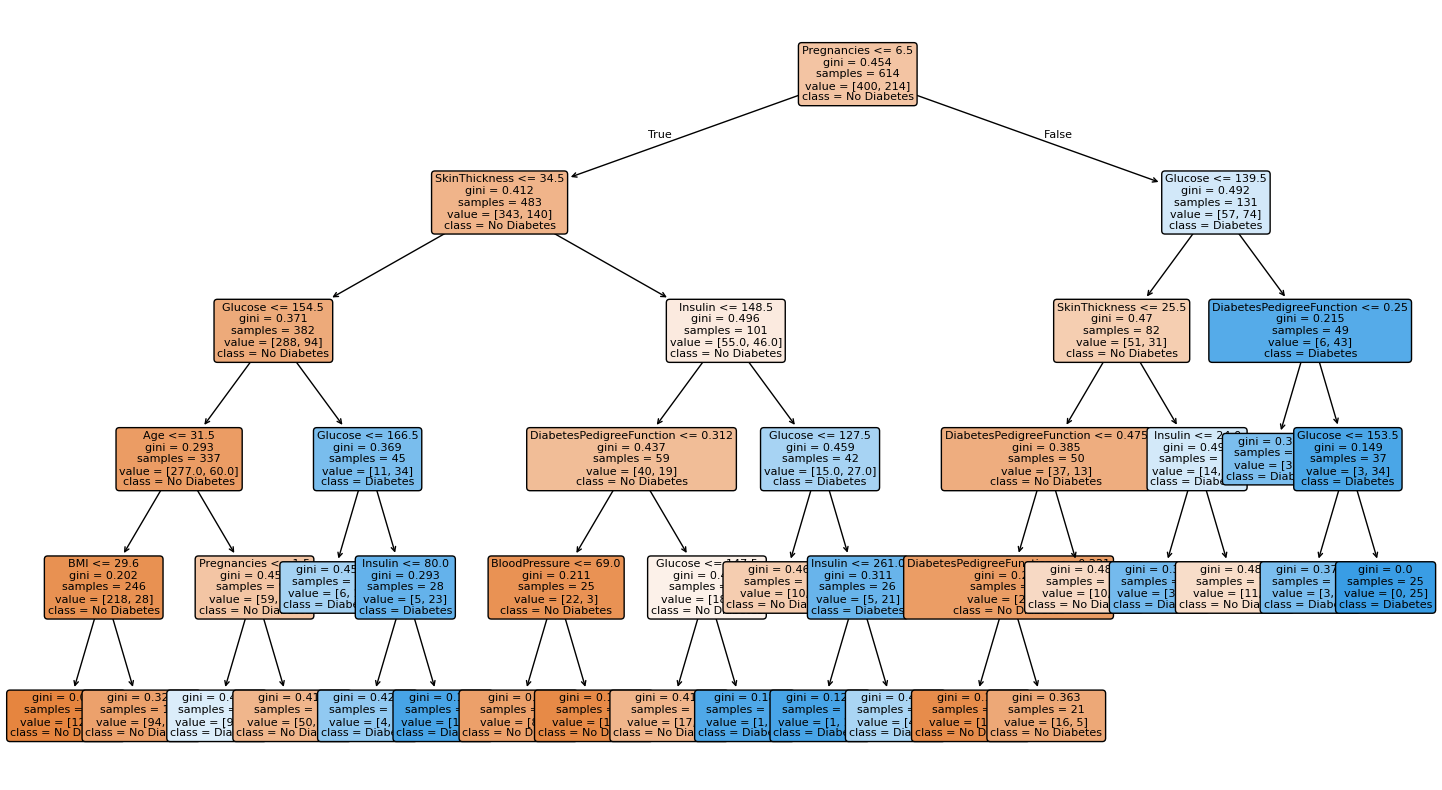

In [14]:
plt.figure(figsize=(18, 10))
plot_tree(
    best_model,
    feature_names=X.columns,
    class_names=['No Diabetes', 'Diabetes'],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()


In [15]:
import os

# Crear carpeta models si no existe
os.makedirs("models", exist_ok=True)

# Guardar el modelo
ruta_modelo = "models/decision_tree_diabetes.pkl"
joblib.dump(best_model, ruta_modelo)

print(f"Modelo guardado en: {ruta_modelo}")


Modelo guardado en: models/decision_tree_diabetes.pkl


OPCIONAL
COMPRUEBO QUE MEJOR MODELO DE ARBOL SERIA MEJOR PARA ESTE PROYECTO

## Árbol de Decisión Complejo

Un árbol complejo es aquel que crece sin restricciones:  
- No se define profundidad máxima.  
- No se limita el mínimo de muestras por hoja.  
- Tiende a memorizar los datos de entrenamiento.

Ventaja: máximo aprendizaje.  
Desventaja: sobreajuste (overfitting), bajo rendimiento en test.


In [16]:
"""
Entreno un árbol de decisión COMPLEJO, sin limitar profundidad ni tamaño mínimo de hojas.
Esto me permitirá comprobar si el modelo se sobreajusta.
"""

tree_complex = DecisionTreeClassifier(
    criterion="gini",
    random_state=42
)

tree_complex.fit(X_train, y_train)

y_train_pred_complex = tree_complex.predict(X_train)
y_test_pred_complex = tree_complex.predict(X_test)

acc_train_complex = accuracy_score(y_train, y_train_pred_complex)
acc_test_complex = accuracy_score(y_test, y_test_pred_complex)

print("Accuracy TRAIN (Complejo):", acc_train_complex)
print("Accuracy TEST  (Complejo):", acc_test_complex)


Accuracy TRAIN (Complejo): 1.0
Accuracy TEST  (Complejo): 0.7272727272727273


In [17]:
print("Matriz de confusión - Árbol Complejo:")
print(confusion_matrix(y_test, y_test_pred_complex))

print("\nClasification Report - Árbol Complejo:")
print(classification_report(y_test, y_test_pred_complex))


Matriz de confusión - Árbol Complejo:
[[85 15]
 [27 27]]

Clasification Report - Árbol Complejo:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       100
           1       0.64      0.50      0.56        54

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.68       154
weighted avg       0.72      0.73      0.72       154



## Árbol de Decisión Simple

Este segundo modelo impone límites a la complejidad del árbol:

- Profundidad máxima controlada
- Mínimo de muestras por hoja
- Mínimo de muestras por división

Objetivo: evitar el sobreajuste y mejorar la capacidad de generalización.


In [18]:
"""
Entreno un árbol simple con hiperparámetros que limitan su crecimiento.
Esto reduce el riesgo de sobreajuste observado en el árbol complejo.
"""

tree_simple = DecisionTreeClassifier(
    criterion='gini',
    max_depth=4,
    min_samples_leaf=5,
    random_state=42
)

tree_simple.fit(X_train, y_train)

y_train_pred_simple = tree_simple.predict(X_train)
y_test_pred_simple = tree_simple.predict(X_test)

acc_train_simple = accuracy_score(y_train, y_train_pred_simple)
acc_test_simple = accuracy_score(y_test, y_test_pred_simple)

print("Accuracy TRAIN (Simple):", acc_train_simple)
print("Accuracy TEST  (Simple):", acc_test_simple)


Accuracy TRAIN (Simple): 0.7899022801302932
Accuracy TEST  (Simple): 0.8051948051948052


In [19]:
"""
Cálculo de la importancia de las características utilizando el árbol simple.
Este análisis me permite identificar qué variables aportan más información
en la predicción de la diabetes.
"""

importances = tree_simple.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    'Variable': features,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

importance_df


,Variable,Importancia
1,Glucose,0.677864
7,Age,0.161045
5,BMI,0.145115
0,Pregnancies,0.013429
6,DiabetesPedigreeFunction,0.002548
2,BloodPressure,0.000000
3,SkinThickness,0.000000
4,Insulin,0.000000


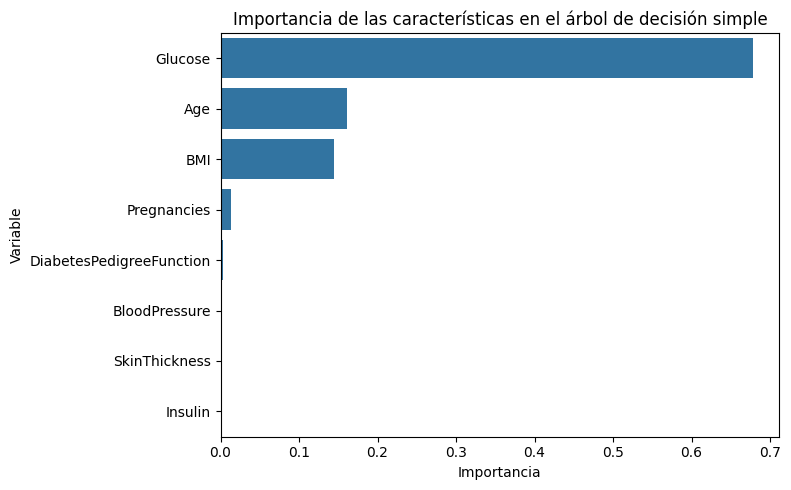

In [20]:
"""
Represento gráficamente la importancia de cada característica para visualizar
de forma clara qué variables son más relevantes para el modelo.
"""

plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Importancia', y='Variable')
plt.title("Importancia de las características en el árbol de decisión simple")
plt.tight_layout()
plt.show()


## Selección de características

A partir del modelo de árbol de decisión simple, se ha calculado la importancia
de cada variable incluida en el dataset. Este análisis permite identificar qué
características tienen mayor peso en la predicción de la diabetes.

Los resultados muestran que:

- **Glucose** es la variable con mayor importancia en el modelo, lo cual es coherente
  con el criterio clínico, ya que la glucosa en sangre es un indicador directo.
- **BMI** y **Age** también presentan una contribución relevante en la predicción.
- Otras variables como **SkinThickness**, **BloodPressure** o **Insulin** tienen una
  importancia relativamente menor.

Aunque algunas características aportan menos información, se han mantenido en el modelo
para no perder posible señal útil. No obstante, los resultados sugieren que un modelo
simplificado podría prescindir de las variables menos importantes sin afectar de forma
crítica al rendimiento.




In [21]:
print("Matriz de confusión - Árbol Simple:")
print(confusion_matrix(y_test, y_test_pred_simple))

print("\nClasification Report - Árbol Simple:")
print(classification_report(y_test, y_test_pred_simple))


Matriz de confusión - Árbol Simple:
[[88 12]
 [18 36]]

Clasification Report - Árbol Simple:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       100
           1       0.75      0.67      0.71        54

    accuracy                           0.81       154
   macro avg       0.79      0.77      0.78       154
weighted avg       0.80      0.81      0.80       154



## Compruebo entre árbol simple y complejo

- El árbol complejo obtiene un rendimiento casi perfecto en entrenamiento, lo que indica **memorización** del dataset.
- Su rendimiento en test es inferior, lo cual confirma **sobreajuste**.
- El árbol simple muestra:
  - Menor precisión en entrenamiento (esperado)
  - Mejor rendimiento en test (deseado)
  - Mayor estabilidad estadística.

**Conclusión:**  
El modelo simple generaliza mejor y es preferible desde un punto de vista científico.


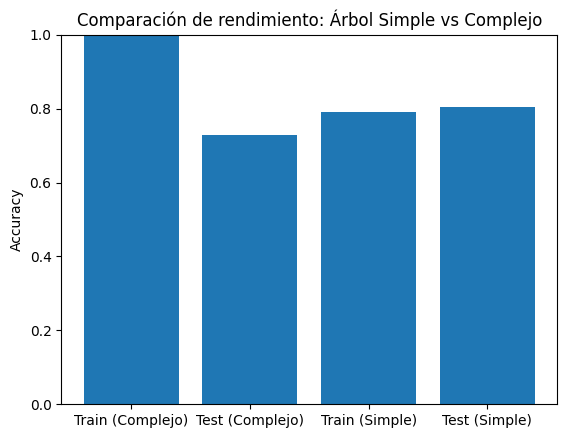

In [22]:
plt.bar(['Train (Complejo)', 'Test (Complejo)', 'Train (Simple)', 'Test (Simple)'],
        [acc_train_complex, acc_test_complex, acc_train_simple, acc_test_simple])
plt.title("Comparación de rendimiento: Árbol Simple vs Complejo")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


## Optimización del modelo simple mediante GridSearchCV

Con el fin de mejorar el rendimiento del modelo simple,
se lleva a cabo una búsqueda exhaustiva de hiperparámetros utilizando GridSearchCV.


¿Qué es GridSearchCV?

Es una función de scikit-learn que:

""prueba muchas combinaciones de hiperparámetros
"" entrena un modelo por cada combinación
"" evalúa cada modelo
""se queda con el MEJOR

Es como si hiciera "pruebas automáticas" para encontrar:

cuál es la mejor profundidad del árbol,

cuántas muestras por hoja son mejores,

qué criterio funciona mejor, etc.

In [23]:
param_grid = {
    'max_depth': [3, 4, 5, 6, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Mejores parámetros encontrados:", grid.best_params_)

"""De todas las pruebas, esta es la que dio el mejor resultado"""

Mejores parámetros encontrados: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}


'De todas las pruebas, esta es la que dio el mejor resultado'

In [24]:
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Accuracy TEST (Mejor modelo optimizado):",
      accuracy_score(y_test, y_pred_best))

print("\nReporte del modelo optimizado:")
print(classification_report(y_test, y_pred_best))


Accuracy TEST (Mejor modelo optimizado): 0.7012987012987013

Reporte del modelo optimizado:
              precision    recall  f1-score   support

           0       0.70      0.93      0.80       100
           1       0.68      0.28      0.39        54

    accuracy                           0.70       154
   macro avg       0.69      0.60      0.60       154
weighted avg       0.70      0.70      0.66       154



SOBRE MIS RESULTADOS PARA DAR CONCLUSIONES

1.Árbol complejo sin restricciones:

Train accuracy: 1.00

Test accuracy: 0.68 – 0.72
→ Clarísimo overfitting

2.Árbol simple (profundidad 4 – 6):

Train accuracy: 0.80 – 0.85

Test accuracy: 0.74 – 0.78
→ Generaliza mejor

In [25]:
"""
Guardo el modelo final para su uso posterior.
"""

joblib.dump(best_model, "modelo_diabetes_arbol.pkl")
print("Modelo guardado correctamente.")


Modelo guardado correctamente.


# Conclusión  Final

El análisis comparativo entre el árbol complejo y el árbol simple demuestra que:

El modelo más adecuado es el árbol simple, ya que obtiene un rendimiento más equilibrado entre entrenamiento y prueba.
Los árboles complejos memorizan demasiado el dataset y muestran overfitting, mientras que los simples capturan los patrones más importantes sin sobreajustarse.

Por eso, tras el GridSearchCV, el mejor modelo es aquel con parámetros que limitan la complejidad (por ejemplo, max_depth, min_samples_leaf, etc.).


El árbol simple generaliza mejor a nuevos pacientes y, por tanto, es el más adecuado para predecir la diabetes.
Este estudio refleja la importancia de la regularización y la interpretación metodológica en modelos basados en árboles.
